In [1]:
import pandas as pd
import glob
from tqdm import tqdm
import os
import re
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import pacf

In [2]:
def concat_csv(data_path:str='./data/'):
    '''Read all csv files in data_path and add them one after another vertically.

    Args:
        data_path (str, optional): The path to look for csv_files. Defaults to './data/'.

    Returns:
        pd.DataFrame: Concatenated pandas dataframe
    '''
    print(f'Reading data from:  {data_path}')
    all_files = glob.glob(os.path.join(data_path , "*.csv"))
    dataframes = []
    row_count = 0
    for filename in tqdm(all_files):
        if filename.endswith('.csv'):
            df = pd.read_csv(filename, index_col=None, header=0)
            row_count += (len(df))
            dataframes.append(df)
    print(f'Total row count: {row_count}')
    frame = pd.concat(dataframes, axis=0)
    return frame

In [3]:
df = concat_csv()
# save the merged data to disk
df.to_csv('merged_reviews.csv')
# Peak the data
print(len(df))
df.head()

Reading data from:  ./data/


100%|██████████| 232/232 [00:02<00:00, 77.50it/s]


Total row count: 199353
199353


,Unnamed: 0,date,review_text,rating
0,0,May 5,Five stars hotel from beginig to end. Permisse...,5
1,1,Feb 2023,Paradise does indeed exist!\nI absolutely LOVE...,4
2,2,Nov 2022,Had an absolutely fantastic time at this prope...,5
3,3,Oct 2022,Hotel is in a beautiful setting and the servic...,4
4,4,Oct 2022,So worthy of their Conde Nast award - and beyo...,5


In [4]:
# Drop the index column
df = df.drop('Unnamed: 0', axis=1)
# Drop the null rows
df = df.dropna()
# See how many rows left
print(len(df))

199242


In [5]:
# Fix the faulty dates of the last month(May)
proper_dates = []
pattern = r'\d{4}$'
# Iterate through date column
for date in df['date'].values:
    # Search for values that ends with 4 numbers which is a year
    if re.search(pattern, date):
        proper_dates.append(date)
    # 
    else:
        proper_dates.append(f'{date[:3]} 2023')

In [6]:
df['date'] = np.array(proper_dates)

In [7]:
df.head()

,date,review_text,rating
0,May 2023,Five stars hotel from beginig to end. Permisse...,5
1,Feb 2023,Paradise does indeed exist!\nI absolutely LOVE...,4
2,Nov 2022,Had an absolutely fantastic time at this prope...,5
3,Oct 2022,Hotel is in a beautiful setting and the servic...,4
4,Oct 2022,So worthy of their Conde Nast award - and beyo...,5


In [8]:
df['date'] = pd.to_datetime(df['date'])

In [9]:
df['date'] = df['date'].apply(lambda x: x.strftime('%Y-%m'))
df

,date,review_text,rating
0,2023-05,Five stars hotel from beginig to end. Permisse...,5
1,2023-02,Paradise does indeed exist!\nI absolutely LOVE...,4
2,2022-11,Had an absolutely fantastic time at this prope...,5
3,2022-10,Hotel is in a beautiful setting and the servic...,4
4,2022-10,So worthy of their Conde Nast award - and beyo...,5
...,...,...,...
975,2017-07,Great hotel! Design and furnishings are beauti...,5
976,2017-07,This is a beautifull hotel with great service!...,5
977,2017-07,This is not a 5 Star hotel! The junior suite w...,2
978,2017-07,I booked this holiday based on the experience ...,4


In [10]:
df['date'] = pd.to_datetime(df['date'])

In [11]:
df.dtypes

date           datetime64[ns]
review_text            object
rating                  int64
dtype: object

In [12]:
GB = df.groupby([(df['date'].dt.year), (df['date'].dt.month),]).mean()
GB

C:\Users\SamOz.py\AppData\Local\Temp\ipykernel_17616\670900290.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  GB = df.groupby([(df['date'].dt.year), (df['date'].dt.month),]).mean()


rating
date date          
2002 9     5.000000
     10    1.000000
     11    5.000000
     12    5.000000
2003 1     5.000000
...             ...
2023 1     4.611952
     2     4.578423
     3     4.588457
     4     4.637500
     5     4.579310

[249 rows x 1 columns]

In [13]:
data = df.groupby(df['date']).mean().unstack(level=0).droplevel(0)

C:\Users\SamOz.py\AppData\Local\Temp\ipykernel_17616\171956137.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = df.groupby(df['date']).mean().unstack(level=0).droplevel(0)


<Axes: xlabel='date'>

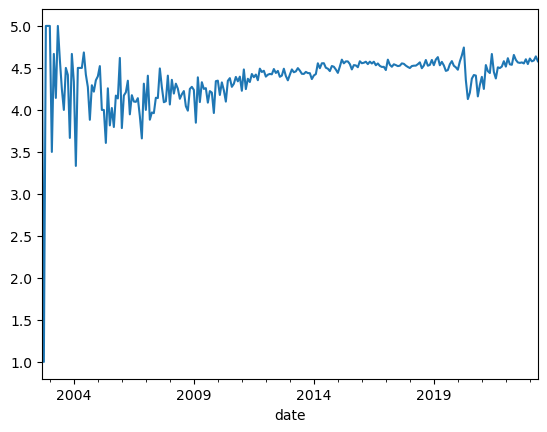

In [14]:
data.plot()

In [15]:
TEST_SIZE = 20
train, test = data.iloc[:-TEST_SIZE], data.iloc[-TEST_SIZE:]
x_train, x_test = np.array(range(train.shape[0])), np.array(range(train.shape[0], data.shape[0]))
train.shape, x_train.shape, test.shape, x_test.shape

((229,), (229,), (20,), (20,))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


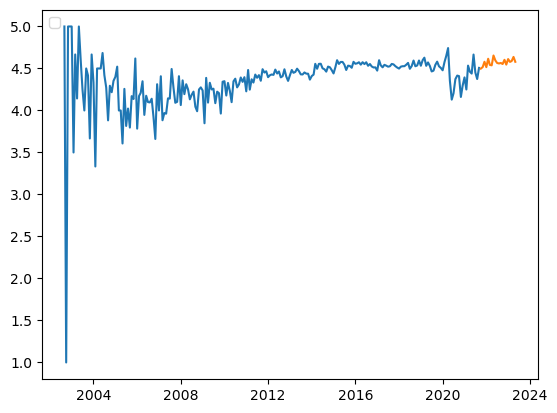

In [16]:
plt.plot(train.index, train.values)
plt.plot(test.index, test.values)
plt.legend(loc='upper left')
plt.show()

In [17]:
from pmdarima.arima import auto_arima
model = auto_arima(train, start_p=1, start_q=1,
                      test='adf',
                      max_p=5, max_q=5,
                      m=1,             
                      d=1,          
                      seasonal=True,   
                      start_P=0, 
                      D=None, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=105.836, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=296.389, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=183.641, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=114.684, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=294.394, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=105.127, Time=0.23 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=170.504, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=89.187, Time=0.23 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=99.454, Time=0.14 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=80.451, Time=0.37 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=99.746, Time=0.20 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=77.108, Time=0.45 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=74.977, Time=0.28 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=73.245, Time=0.16 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=97.959, Time

In [34]:
# Forecast

prediction, confint = model.predict(n_periods=TEST_SIZE, return_conf_int=True)

prediction

2021-10-01    4.586900
2021-11-01    4.456019
2021-12-01    4.495331
2022-01-01    4.473614
2022-02-01    4.492758
2022-03-01    4.487669
2022-04-01    4.537465
2022-05-01    4.463347
2022-06-01    4.488838
2022-07-01    4.482549
2022-08-01    4.519812
2022-09-01    4.477120
2022-10-01    4.507664
2022-11-01    4.472803
2022-12-01    4.505223
2023-01-01    4.482196
2023-02-01    4.512788
2023-03-01    4.474983
2023-04-01    4.504340
2023-05-01    4.478956
Freq: MS, dtype: float64

In [35]:
cf= pd.DataFrame(confint)

In [36]:
prediction.index.dtype

dtype('<M8[ns]')

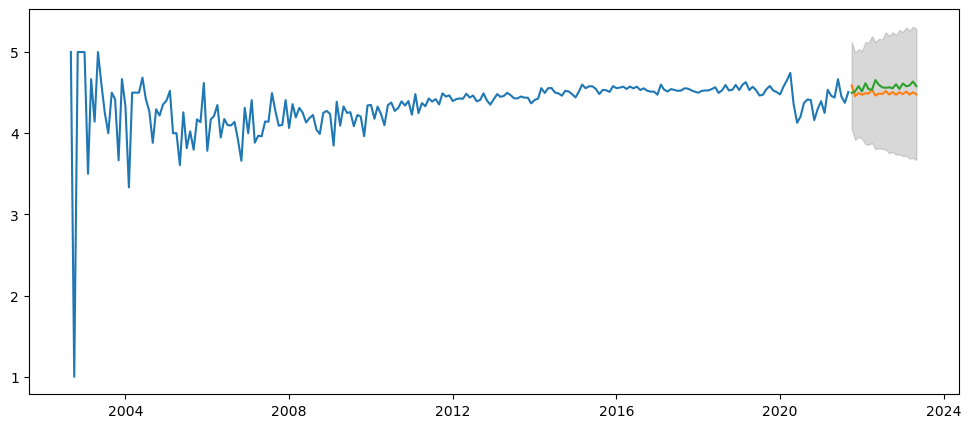

In [31]:
#Mostramos la gráfica con la predicción de los 2 últimos años en naranja
#sobre la serie real 
prediction_series = pd.Series(prediction,index=test.index)
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.plot(train.index, train.values)
ax.plot(prediction_series)
ax.plot(test.index, test.values)
ax.fill_between(prediction_series.index,
                cf[0],
                cf[1],color='grey',alpha=.3)

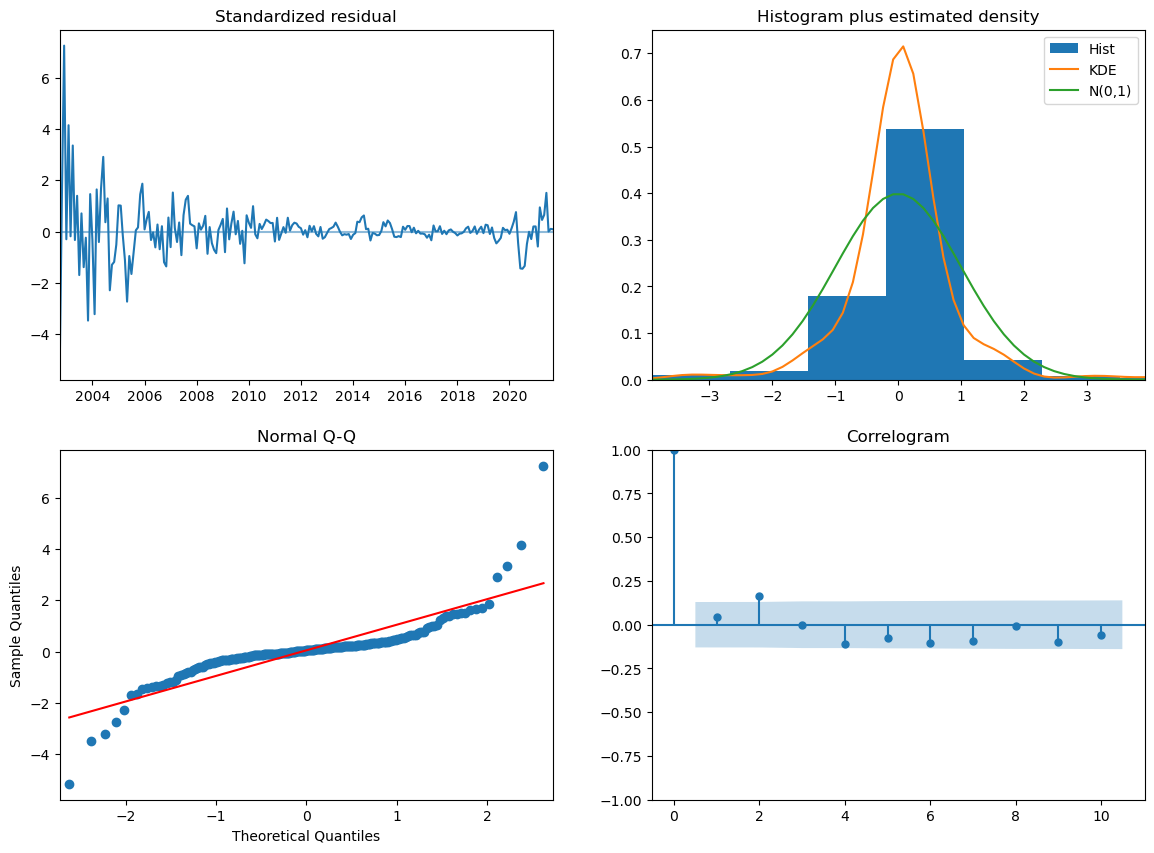

In [37]:
model.plot_diagnostics(figsize=(14,10))
plt.show()

In [38]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  229
Model:               SARIMAX(5, 1, 0)   Log Likelihood                 -30.622
Date:                Mon, 22 May 2023   AIC                             73.245
Time:                        22:03:35   BIC                             93.821
Sample:                    09-01-2002   HQIC                            81.546
                         - 09-01-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0257      0.071    -14.390      0.000      -1.165      -0.886
ar.L2         -1.1263      0.077    -14.576      0.000      -1.278      -0.975
ar.L3         -1.1492      0.071    -16.095      0.000      -1.289      -1.009
ar.L4         -0.5647      0.076     -7.452      0.000      -0.713      -0.416
ar.L5         -0.4843      0.023    -21.449      0.000      -0.529      -0.440
sigma2         0.0751      0.003     22.110      0.000       0.068       0.082
===================================================================================
Ljung-Box (L1) (Q):                   0.45   Jarque-Bera (JB):              2574.99
Prob(Q):                              0.50   Prob(JB):                         0.00
Heteroskedasticity (H):               0.06   Skew:                             1.11
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""